In [1]:
import torch
import worch
from worch import nn
from worch import optim
from test_utils import generate_data
import matplotlib.pyplot as plt
torch.set_grad_enabled(False)
%load_ext autoreload
%autoreload 2

In [2]:
x = torch.empty((2, 2)).normal_()
y = torch.empty((2, 2)).normal_()

# Linear

In [3]:
wfc = worch.nn.Linear(x.shape[1], 10)
tfc = torch.nn.Linear(x.shape[1], 10)
p = tfc.state_dict()
wfc.params[0].shape == p['weight'].shape

True

In [4]:
wfc.weights = p['weight']
wfc.bias=p['bias']

In [5]:
(wfc(x)).allclose(tfc(x))

False

In [6]:
torch.max(torch.abs(wfc(x)-tfc(x)))

tensor(1.5928)

# ReLU

In [7]:
(worch.nn.ReLU()(x)).allclose(torch.nn.ReLU()(x))

True

In [8]:
torch.max(torch.abs(worch.nn.ReLU()(x)-torch.nn.ReLU()(x)))

tensor(0.)

# Sigmoid

In [9]:
(worch.nn.Sigmoid()(x)).allclose(torch.nn.Sigmoid()(x))

True

In [10]:
torch.max(torch.abs(worch.nn.Sigmoid()(x)-torch.nn.Sigmoid()(x)))

tensor(5.9605e-08)

# Tanh

In [11]:
(worch.nn.Tanh()(x)).allclose(torch.nn.Tanh()(x))

True

In [12]:
torch.max(torch.abs(worch.nn.Tanh()(x)-torch.nn.Tanh()(x)))

tensor(5.9605e-08)

# MSE

In [13]:
(worch.nn.MSELoss()(x, y)).allclose(torch.nn.MSELoss()(x, y))

True

In [14]:
torch.max(worch.nn.MSELoss()(x, y)-torch.nn.MSELoss()(x, y))

tensor(0.)

# Sequential

In [15]:
wfc1 = worch.nn.Linear(x.shape[1], 10)
tfc1 = torch.nn.Linear(x.shape[1], 10)
p = tfc1.state_dict()
wfc1.weights = p['weight']
wfc1.bias=p['bias']
wfc2 = worch.nn.Linear(10, 3)
tfc2 = torch.nn.Linear(10, 3)
p = tfc2.state_dict()
wfc2.weights = p['weight']
wfc2.bias=p['bias']

In [16]:
wnet =  worch.nn.Sequential(
    wfc1,
    worch.nn.ReLU(),
    wfc2,
)
tnet =  torch.nn.Sequential(
    tfc1,
    torch.nn.ReLU(),
    tfc2,
)

In [17]:
(wnet(x)).allclose(tnet(x))

False

In [18]:
torch.max(torch.abs(wnet(x)-tnet(x)))

tensor(1.3749)

# Training

In [19]:
'''
todo: make same model with pytorch and see difference
'''

'\ntodo: make same model with pytorch and see difference\n'

In [20]:
X, Y = generate_data(n=1000)

In [21]:
X.shape, Y.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

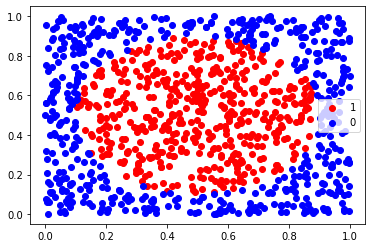

In [22]:
# Plot data
X1 = X[Y.squeeze(-1).bool()].numpy()
X0 = X[~Y.squeeze(-1).bool()].numpy()
plt.scatter(X1[:,0], X1[:,1], color='r', label='1')
plt.scatter(X0[:,0], X0[:,1], color='b', label='0')
plt.legend()
plt.rcParams['figure.figsize'] = (9,9)
plt.show()

In [23]:
# Standardization
X_test, Y_test = generate_data(n=1000)
mu, std = X.mean(0), X.std(0)
X = X.sub_(mu).div_(std)
X_test = X_test.sub_(mu).div_(std)

In [24]:
device = 'cpu'
model =  worch.nn.Sequential(
    worch.nn.Linear(X.shape[1], 4),
    worch.nn.ReLU(),
    worch.nn.Linear(4, 16),
    worch.nn.ReLU(),
    worch.nn.Linear(16, 1)
)
model.to(device)
optimizer = worch.optim.SGD(model.parameters(), lr=0.001)
criterion = worch.nn.MSELoss()
# Required boilerplate because the tensor do not carry the gradfn attributes along, all in the modules
criterion.register_previous_module(model.module_list[-1])

In [25]:
num_epochs = 1500
batch_size = 100
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # Training
    model.train()
    losses = []
    for b in range(0, X.size(0), batch_size):
        x, y = X[b:b+batch_size], Y[b:b+batch_size].long()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        criterion.backward() # call on module not tensor
        optimizer.step()
        losses.append(loss.cpu().detach().item())
    mean_loss = torch.mean(torch.Tensor(losses))
    train_losses.append(mean_loss)
    # Evaluation
    model.eval()
    losses = []
    for b in range(0, X_test.size(0), batch_size):
        x, y = X_test[b:b+batch_size], Y_test[b:b+batch_size].long()
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        losses.append(loss.cpu().detach().item())
    mean_loss = torch.mean(torch.Tensor(losses))
    test_losses.append(mean_loss)
    # Feedback
    if epoch == 0 or(epoch+1) % 50  == 0:
        print(f'[{epoch+1}/{num_epochs}] train loss = {train_losses[-1]}, test loss = {test_losses[-1]}')

[1/1500] train loss = 0.4356306493282318, test loss = 0.2552110552787781
[50/1500] train loss = 0.24846546351909637, test loss = 0.2529887855052948
[100/1500] train loss = 0.24833638966083527, test loss = 0.253688246011734
[150/1500] train loss = 0.24825087189674377, test loss = 0.2538453936576843
[200/1500] train loss = 0.24817132949829102, test loss = 0.2539403736591339
[250/1500] train loss = 0.24809694290161133, test loss = 0.25402769446372986
[300/1500] train loss = 0.2480272352695465, test loss = 0.25411319732666016
[350/1500] train loss = 0.24796171486377716, test loss = 0.25419729948043823
[400/1500] train loss = 0.2478998601436615, test loss = 0.2542800307273865
[450/1500] train loss = 0.24784143269062042, test loss = 0.2543613314628601
[500/1500] train loss = 0.24778597056865692, test loss = 0.25444117188453674
[550/1500] train loss = 0.24773330986499786, test loss = 0.2545194923877716
[600/1500] train loss = 0.24768313765525818, test loss = 0.25459641218185425
[650/1500] tra

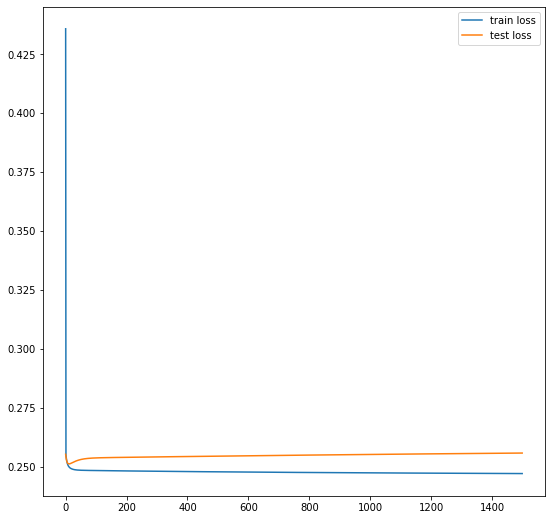

In [26]:
plt.plot(list(range(num_epochs)), train_losses, label='train loss')
plt.plot(list(range(num_epochs)), test_losses, label='test loss')
plt.legend()
plt.show()